In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.linalg import cho_solve, cho_factor
from tqdm import tqdm
import open3d as o3d
from itertools import chain
from pathlib import Path
import json

import sys
np.set_printoptions(precision=4, linewidth=200, sign=" ")
plt.rcParams["figure.figsize"] = [15,10]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Data loading

In [2]:
file_name = "chris_center_start"
transform_details ="_5_1"
rust_path = Path(r"C:\Users\chris\Documents\Work\Polymetrix\Rust\CruxTest")

frame_data_path = rust_path / "preprocessing/examples/output" / file_name
transform_data_path = rust_path / "matcher/examples/output/final_transform" / f"{file_name}{transform_details}.json"

In [3]:
def flatten(x: [[]]):
    return [y for xs in x for y in xs]

In [4]:
# frames = []

# for f in tqdm(sorted(list(frame_data_path.glob("*.json")))):
#     with open(f, "r") as inp:
#         frame_data = json.load(inp)
#         positions, normals = zip(*tuple(map(lambda x: (x["position"], x["normal"]), filter(lambda x: x["valid"], flatten(frame_data["frame"])))))
#         positions, normals = np.array(positions), np.array(normals)

#         frames.append({"positions": positions, "normals": normals})

In [5]:
transforms = []

with open(transform_data_path, "r") as inp:
    data = json.load(inp)
    transforms = [np.array(x).reshape((4,4)).T for x in data]

## Visualisation

In [6]:
def create_axis(transform, colour, size=0.2):
    mesh = o3d.geometry.TriangleMesh.create_coordinate_frame(size=size, origin=np.array([0.0,0.0,0.0]))
    mesh.paint_uniform_color(colour)
    mesh.transform(transform)
    return mesh

In [7]:
stride = 10
poses = [create_axis(x, [0.7,0.2,0.2] if i % stride else [0.9,0,0], 0.01 if i % stride else 0.025) for i, x in enumerate(transforms)]


o3d.visualization.draw_geometries([x for x in chain(poses, [create_axis(np.eye(4), [0,0,0], 0.05)])])

## Selecting Loop Closures

In [8]:
def np_cross(x):
    return np.array([
        [0,-x[2],x[1]],
        [x[2],0,-x[0]],
        [-x[1],x[0],0]
    ])

def np_exp(x):
    theta = np.linalg.norm(x[3:])
    if theta == 0:
        R = np.eye(3)
        t = x[:3]
    else:
        a = np.sin(theta)/theta
        b = (1 - np.cos(theta))/(theta*theta)
        c = (theta - np.sin(theta))/(theta**3)
        w = np_cross(x[3:])
        R = np.eye(3) + a*w + b*w@w

        t = (np.eye(3) + b*w + c*w@w)@x[:3]
    
    mat = np.eye(4)
    mat[:3, :3] = R
    mat[:3, 3] = t

    return mat

def np_log(T):
    theta = np.arccos(np.clip((np.trace(T) - 2) / 2, -1, 1))
    # theta = np.arccos((T[0, 0] + T[1, 1] + T[2, 2] - 1) / 2)


    if theta == 0:
        return np.array([T[0, 3], T[1, 3], T[2, 3], 0, 0, 0
])
    a = np.sin(theta)/theta
    b = (1 - np.cos(theta))/(theta*theta)

    x4 = 1/(2*a)*(T[2, 1] - T[1, 2])
    x5 = 1/(2*a)*(T[0, 2] - T[2, 0])
    x6 = 1/(2*a)*(T[1, 0] - T[0, 1])
    
    w = np_cross(np.array([x4,x5,x6]))
    u = (np.eye(3) - 1/2*w + 1/(theta**2)*(1 - a/(2*b))*w@w)@T[:3, 3]

    return np.array([u[0], u[1], u[2], x4, x5, x6])

(0.014349560634174047, 98)
(0.01433880034710364, 54)
(0.015928516389477898, 47)
(0.007756140940608163, 44)
(0.05538356995365815, 28)
(0.01540300241954876, 15)
(0.03151701473887207, 94)
(0.016780720307840006, 85)
(0.09295876934328103, 68)
(0.028848537385909995, 64)


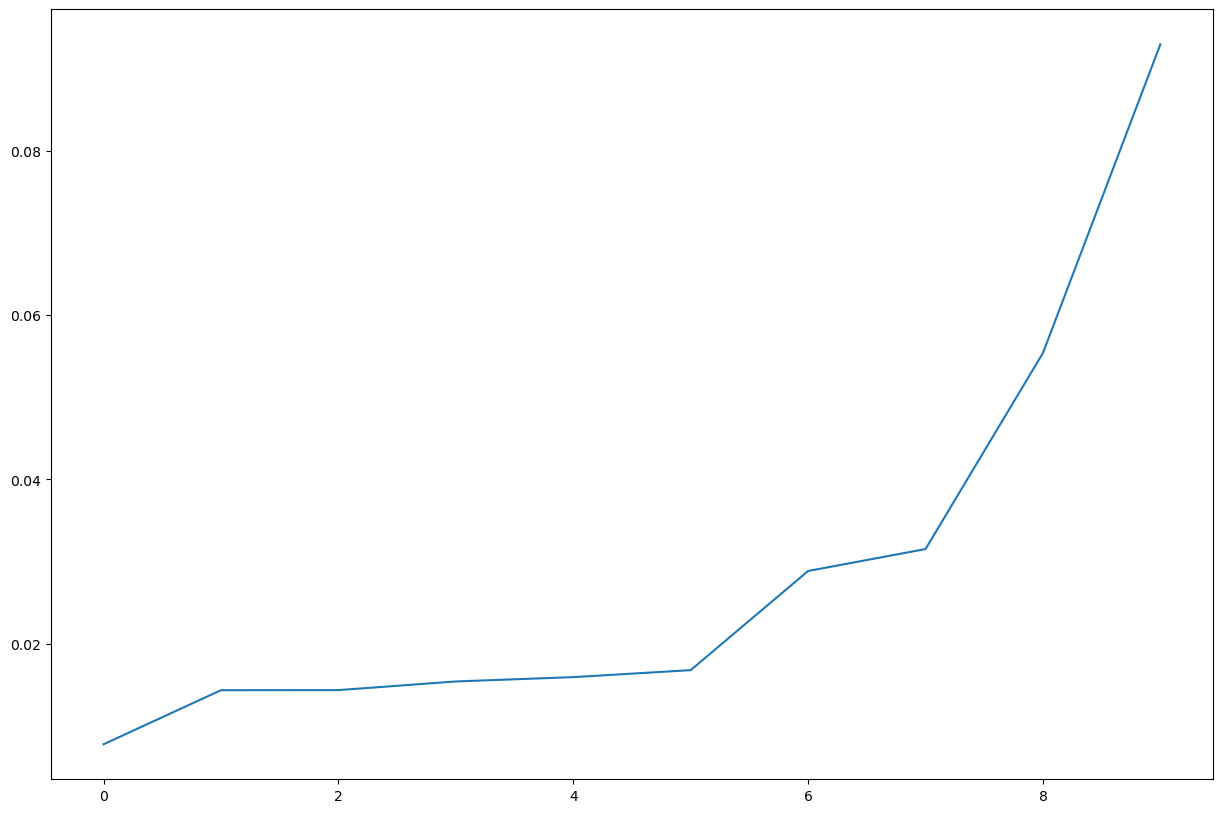

In [9]:
threshold_distance = 12
best_matches = []

for i in range(0, len(transforms), stride):
    a = transforms[i][:3, 3]
    best_match = (500, -1)
    for j in range(0, len(transforms)):
        if abs(i - j) < threshold_distance:
            continue
        b = transforms[j][:3, 3]
        best_match = min(best_match, (np.linalg.norm(a - b), j))
    best_matches.append(best_match)
    print(best_match)

plt.plot(sorted([x for x, _ in best_matches]))

In [10]:
stride = 10

poses = [create_axis(x, [0.7,0.2,0.2] if i % stride else [0.9,0,0], 0.01 if i % stride else 0.025) for i, x in enumerate(transforms)]
matches = [create_axis(transforms[x], [0.2,0.7,0.2], 0.025) for _, x in filter(lambda x: x[0] < 0.035, best_matches)]


o3d.visualization.draw_geometries([x for x in chain(poses, matches, [create_axis(np.eye(4), [0,0,0], 0.05)])])

(0.0, 50.0)

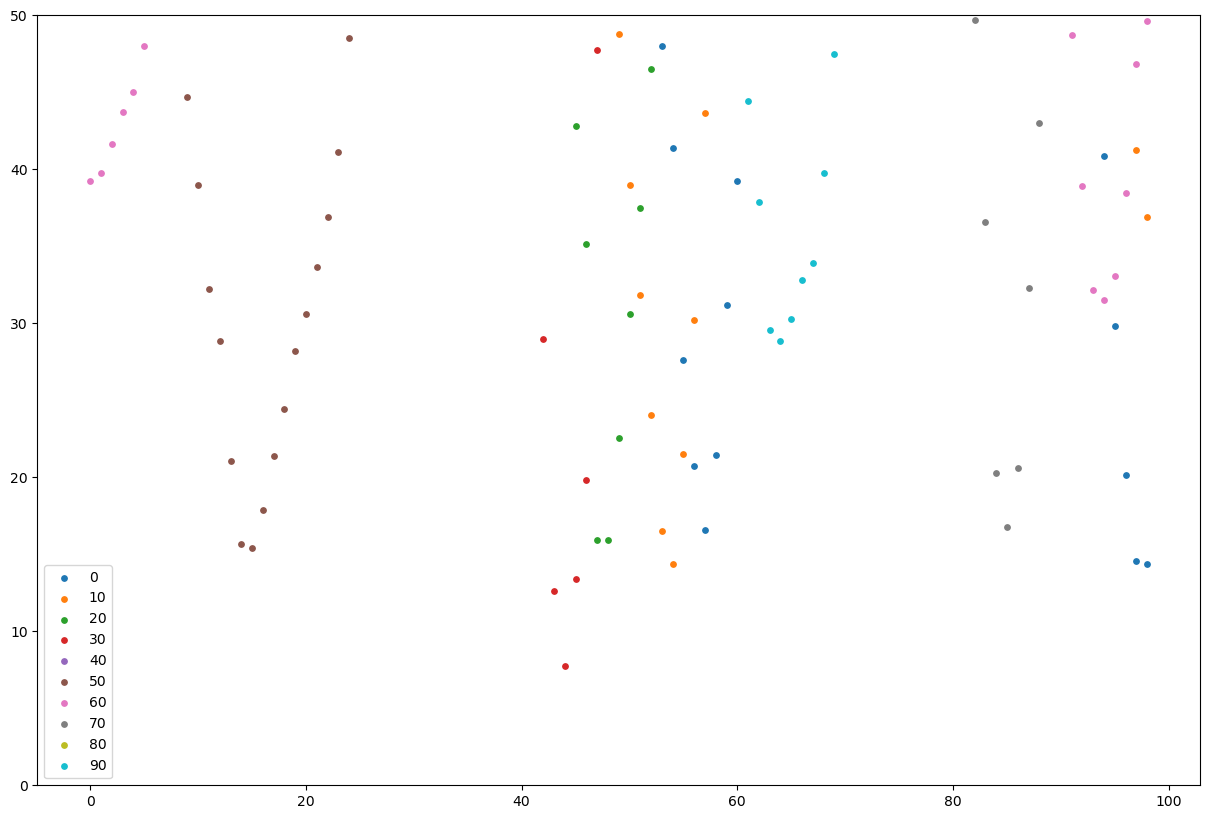

In [13]:
threshold_distance = 12
stride = 10

for i in range(0, len(transforms), stride):
    a = transforms[i]
    xs = []
    ys = []
    for j in range(0, len(transforms)):
        if abs(i - j) < threshold_distance:
            continue
        b = transforms[j]

        xs.append(j)
        # ys.append(np.arccos(np.clip(np.dot(a[:3, 2], b[:3, 2]), -1, 1)))
        ys.append(np.linalg.norm(a[:3,3] - b[:3,3])*1000)

        if ys[-1] < 0.1:
            print(f"{i}\t {j}\t {ys[-1]:.4f}      {np.linalg.norm(a[:3,3] - b[:3,3])*1000:.2f}")

    print()
    plt.scatter(xs, ys, s=15, label=f"{i}")

plt.legend()
plt.ylim((0,50))


In [15]:
threshold_distance = 12
stride = 10
best_matches = []

for i in range(0, len(transforms), stride):
    a = transforms[i]
    best_match = [(128, 5000)]
    for j in range(0, len(transforms)):
        if abs(i - j) < threshold_distance:
            continue
        b = transforms[j]

        if np.linalg.norm(a[:3,3] - b[:3,3]) < 0.05 and np.arccos(np.clip(np.dot(a[:3, 2], b[:3, 2]), -1, 1)) < 0.1:
            score = np.linalg.norm(a[:3,3] - b[:3,3]) * np.arccos(np.clip(np.dot(a[:3, 2], b[:3, 2]), -1, 1))

            if j - best_match[-1][1] > threshold_distance:
                best_match.append((score, j))
            elif best_match[-1][0] > score:
                best_match[-1] = (score, j)

    if best_match[0] == (128,5000):
        best_matches.append([])
    else:
        best_matches.append(best_match)

for m in best_matches:
    print(m)

[(0.000434344985888684, 57), (0.0003506030253043731, 97)]
[(0.00014924323305713373, 54)]
[(0.00038843848933134124, 47)]
[(0.00013755241345070966, 44)]
[]
[(0.000141383094902537, 14)]
[(0.0006977838170386598, 92)]
[(0.00026546124614814005, 84)]
[]
[(0.001087425065416767, 63)]


In [17]:
def get_candidates(transforms, stride=10, temporal_distance=12, angle=0.1, distance=0.05):
    best_matches = []

    for i in range(0, len(transforms), stride):
        a = transforms[i]
        best_match = [(128, 5000)]
        for j in range(0, len(transforms)):
            if abs(i - j) < threshold_distance:
                continue
            b = transforms[j]

            if np.linalg.norm(a[:3,3] - b[:3,3]) < 0.05 and np.arccos(np.clip(np.dot(a[:3, 2], b[:3, 2]), -1, 1)) < 0.1:
                score = np.linalg.norm(a[:3,3] - b[:3,3]) * np.arccos(np.clip(np.dot(a[:3, 2], b[:3, 2]), -1, 1))

                if j - best_match[-1][1] > threshold_distance:
                    best_match.append((score, j))
                elif best_match[-1][0] > score:
                    best_match[-1] = (score, j)

        if best_match[0] == (128,5000):
            continue
        else:
            for _, j in best_match:
                best_matches.append((i, j))
    
    return best_matches

get_candidates(transforms)

[(0, 57),
 (0, 97),
 (5, 56),
 (5, 98),
 (10, 54),
 (15, 49),
 (20, 47),
 (25, 46),
 (30, 44),
 (45, 27),
 (50, 14),
 (55, 7),
 (55, 98),
 (60, 92),
 (65, 88),
 (70, 84),
 (85, 69),
 (90, 63),
 (95, 0),
 (95, 58)]